## Gender Prediction from First Name using KNN

In [14]:
import hashlib
import numpy as np
import pandas as pd
from Levenshtein import distance
import matplotlib.pyplot as plt

In [15]:
# Generating a personalized random seed
username = "prit.kanadiya"
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
print(seed)

1379217023


In [16]:
df = pd.read_csv("../assets/data/gender.csv")
df["Name"] = df["Name"].str.lower()    # Keeping all names in lowercase
print(df.head())

      Name  Target
0     yash       1
1     prit       1
2     meet       1
3  drashti       0
4   saloni       0


In [17]:
class KNN():
    def __init__(self, k: int, metric: str = "euclidean", weights: str = "uniform"):
        self.k = k
        self.weights = weights
        self.metric = metric    # [euclidean, manhattan, edit]
    
    def calculate_distance(self, p, q):
        if (self.metric == "euclidean"):
            dist = np.sqrt(np.sum((p - q) ** 2))
        elif (self.metric == "manhattan"):
            dist = np.sum(abs(p - q))
        elif (self.metric == "edit"):
            dist = distance(p, q)
        
        return dist
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def is_vowel(self, x):
        if (x == "a" or x == "e" or x == "i" or x == "o" or x == "u"):
            return True
    
    def predict(self, X, use_heurisitc = False):
        X_train = self.X_train.copy()
        y_train = self.y_train.copy()

        votes = []
        preds = []
        for i in range(len(X)):
            dist = []
            for j in range(len(self.X_train)):
                dist.append(self.calculate_distance(X[i], X_train[j]))

            dist = np.array(dist)
            idx = np.argsort(dist)
            dist = dist[idx]
            X_train = X_train[idx] 
            y_train = y_train[idx]   

            neighbors = X_train[:self.k]
            labels = y_train[:self.k]
            dist = dist[:self.k]

            # Using our domain knowledge, we know that for two names, if the edit distance is 1 and it is the last letter in train or test sample which gives this edit distance, then flipped y is better representation for test, if the last letter was a vowel
            # For example, Shrey and Shreya differ by edit distance of 1, which is caused by vowel. Thus, they are opposite genders.
            # We can use this heuristic for better voting
            # While I believed this heurisitc would work, it did not improve accuracy or logistic loss on validation
            if (self.metric == "edit" and use_heurisitc):
                for k in range(len(neighbors)):
                    if (self.calculate_distance(neighbors[k], X[i]) == 1):
                        if (len(neighbors[k]) > len(X[i]) and self.is_vowel(neighbors[k][-1])):
                            labels[k] = 1 - labels[k]
                        elif (len(neighbors[k]) < len(X[i]) and self.is_vowel(X[i][-1])):
                            labels[k] = 1 - labels[k]
                            


            if (self.weights == "uniform"):
                vote = np.mean(labels)    # Vote loosely tells us the confidence that the model has on sample belonging to specific class
                if (vote >= 0.5):
                    pred = 1
                else:
                    pred = 0
            elif (self.weights == "distance"):
                eps = 1e-6    # For cases when the test is present in train data
                weights = 1 / (dist + eps)
                vote = np.sum(weights * labels) / np.sum(weights)

                if (vote >= 0.5):
                    pred = 1
                else:
                    pred = 0
            
            preds.append(pred)
            votes.append(vote)
            
        return preds, votes
    
    def get_accuracy(self, X, y, use_heurisitc = False):
        preds, votes = self.predict(X, use_heurisitc)
        confusion_matrix = np.zeros((2,2))

        for i in range(len(y)):
            if (preds[i] == y[i] and y[i] == 0):
                confusion_matrix[0][0] += 1
            elif (preds[i] == y[i] and y[i] == 1):
                confusion_matrix[1][1] += 1
            elif (preds[i] != y[i] and y[i] == 0):
                confusion_matrix[0][1] += 1
            elif (preds[i] != y[i] and y[i] == 1):
                confusion_matrix[1][0] += 1
        
        accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1]) / (confusion_matrix[0][0] + confusion_matrix[0][1] + confusion_matrix[1][0]+ confusion_matrix[1][1])

        return accuracy, confusion_matrix

    # Because we can get an estimate of confidence from votes, we will use logistic loss value for tuning hyperparameters
    def get_logistic_loss(self, X, y, use_heurisitc = False):
        preds, votes = self.predict(X, use_heurisitc)

        loss = 0
        eps = 1e-6
        for i in range(len(y)):
            loss += y[i]*np.log(preds[i] + eps) + (1-y[i])*np.log((1-preds[i]) + eps)
        
        loss /= len(y)
        return -loss
            

In [18]:
# Preprocessing data to remove repeated names
print(df.info())
df = df.drop_duplicates()    # This removes duplicate rows, but not the conflicting ones like same X's but with different y's

print("After removing duplicates:")
print(df.info())

print(len(df["Name"].unique()))    # This means there are a few names which are repeated

# Because number of unique rows and number of unique names are the same, we know there is no conflicting data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    1294 non-null   object
 1   Target  1294 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.3+ KB
None
After removing duplicates:
<class 'pandas.core.frame.DataFrame'>
Index: 1179 entries, 0 to 1291
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    1179 non-null   object
 1   Target  1179 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.6+ KB
None
1179


In [19]:
# Separating X and y and splitting dataset into train, validation and test
X = df["Name"].to_numpy()
y = df["Target"].to_numpy()

val_split = 0.1
test_split = 0.1

X_train = X[:int(len(y)*(1-test_split-val_split))]
X_val = X[int(len(y)*(1-test_split-val_split)): int(len(y)*(1-val_split))]
X_test = X[int(len(y)*(1-val_split)):]
y_train = y[:int(len(y)*(1-test_split-val_split))]
y_val = y[int(len(y)*(1-test_split-val_split)): int(len(y)*(1-val_split))]
y_test = y[int(len(y)*(1-val_split)):]

print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Validation data: {X_val.shape}, {y_val.shape}")
print(f"Testing data: {X_test.shape}, {y_test.shape}")


Training data: (943,), (943,)
Validation data: (118,), (118,)
Testing data: (118,), (118,)


In [20]:
knn = KNN(k=5, metric="edit", weights="uniform")
knn.fit(X_train, y_train)
preds, votes = knn.predict(X_val)

In [21]:
accuracy, confusion_matrix = knn.get_accuracy(X_val, y_val)
loss = knn.get_logistic_loss(X_val, y_val)

print(f"Accuracy: {accuracy}")
print(confusion_matrix)
print(f"Loss: {loss}")

Accuracy: 0.8050847457627118
[[51. 10.]
 [13. 44.]]
Loss: 2.6928529477392047


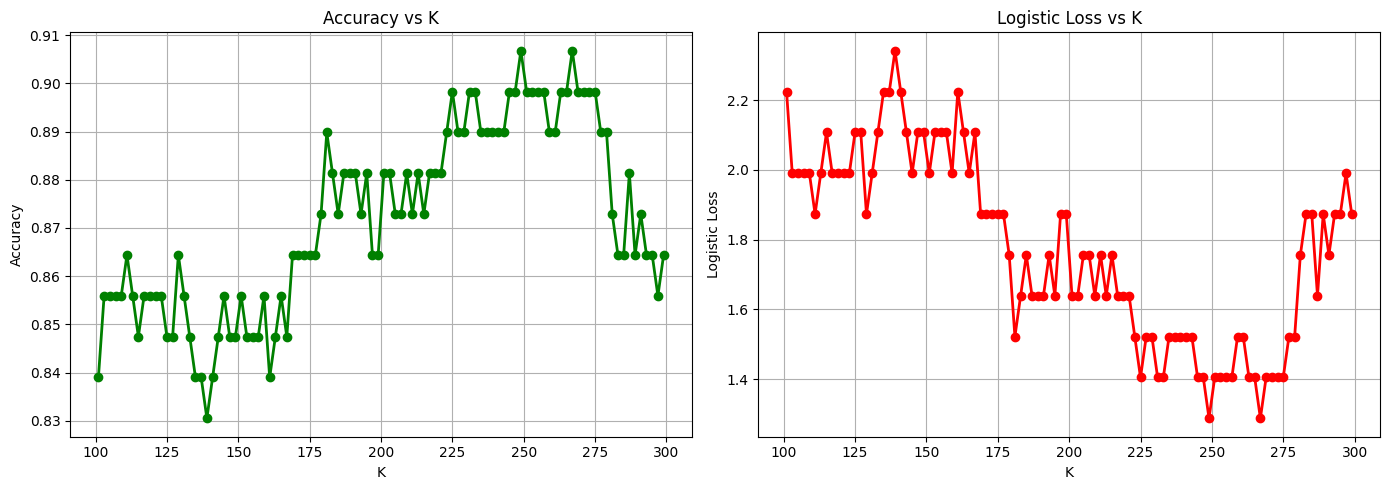

In [22]:
# Trying several values of K over validation set
accuracy_list = []
loss_list = []
K_list = [i for i in range(101, 300, 2)]
for K in K_list:
    knn = KNN(k=K, metric="edit", weights="uniform")
    knn.fit(X_train, y_train)
    accuracy, confusion_matrix = knn.get_accuracy(X_val, y_val)
    loss = knn.get_logistic_loss(X_val, y_val)

    accuracy_list.append(accuracy)
    loss_list.append(loss)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(K_list, accuracy_list, color='green', marker='o', linewidth=2)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Accuracy vs K")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K_list, loss_list, color='red', marker='o', linewidth=2)
plt.xlabel("K")
plt.ylabel("Logistic Loss")
plt.title("Logistic Loss vs K")
plt.grid(True)

plt.tight_layout()
plt.show()

The best values of accuracy and logistic loss for uniform weights is found when K is around 250ish. 

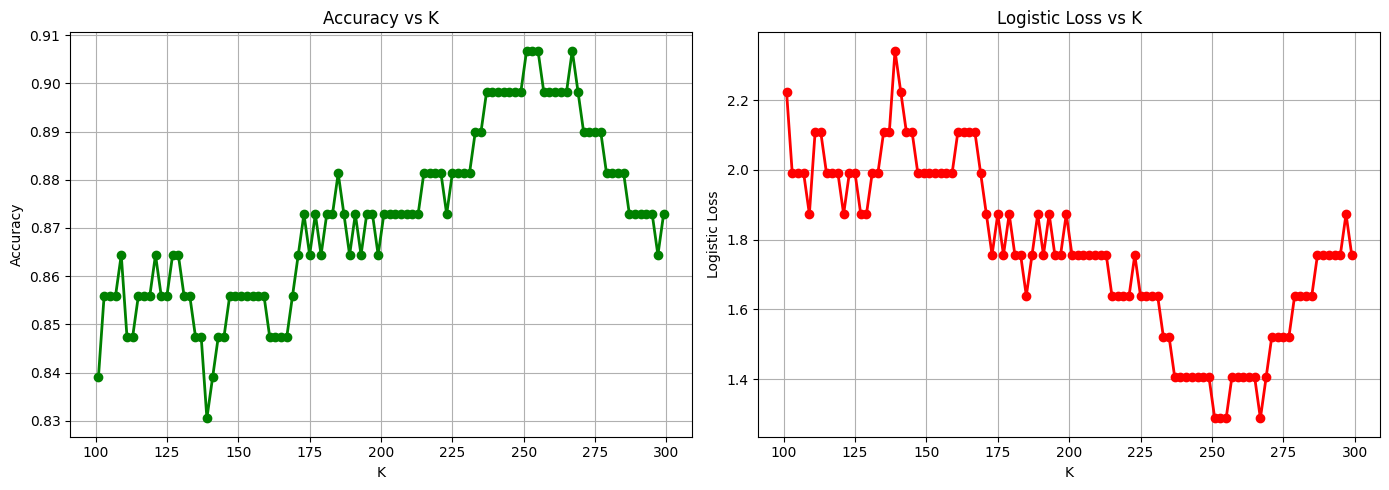

In [23]:
# Trying several values of K over validation set
accuracy_list = []
loss_list = []
K_list = [i for i in range(101, 300, 2)]
for K in K_list:
    knn = KNN(k=K, metric="edit", weights="distance")
    knn.fit(X_train, y_train)
    accuracy, confusion_matrix = knn.get_accuracy(X_val, y_val)
    loss = knn.get_logistic_loss(X_val, y_val)

    accuracy_list.append(accuracy)
    loss_list.append(loss)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(K_list, accuracy_list, color='green', marker='o', linewidth=2)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Accuracy vs K")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K_list, loss_list, color='red', marker='o', linewidth=2)
plt.xlabel("K")
plt.ylabel("Logistic Loss")
plt.title("Logistic Loss vs K")
plt.grid(True)

plt.tight_layout()
plt.show()

The best values of accuracy and logistic loss for distance weights is found when K is around 250ish. We see a similar trend as KNN with uniform weights, but the curve looks more stable than uniform weights.

In [24]:
# Evaluating model on test dataset
knn = KNN(k=251, metric="edit", weights="distance")

X_train_combined = np.concatenate((X_train, X_val))
y_train_combined = np.concatenate((y_train, y_val))

knn.fit(X_train_combined, y_train_combined)

accuracy, confusion_matrix = knn.get_accuracy(X_test, y_test)
loss = knn.get_logistic_loss(X_test, y_test)

print(f"Accuracy: {accuracy}")
print(confusion_matrix)
print(f"Loss: {loss}")

Accuracy: 0.847457627118644
[[72.  7.]
 [11. 28.]]
Loss: 2.1074499156220994


Hence, the accuracy obtained by the KNN model with `K = 251` and `distance` weighted is `84.75%`

In [27]:
# Running model for custom names
names = ["Emma", "Jacob", "Preetika", "Raavan", "Mandodari", "Zooni", "Chandanbala"]

# These are foreign names, so they won't perform as well as Indian names since the data used comes from Indian names only.
# names = ["Carlos", "Hermoine", "Leonardo", "Meryl", "Dwayne", "Cate", "Valkayrie", "Obama"]  
  
knn = KNN(k=251, metric="edit", weights="distance")

X_train_combined = np.concatenate((X_train, X_val, X_test))
y_train_combined = np.concatenate((y_train, y_val, y_test))

knn.fit(X_train_combined, y_train_combined)

names = [name.lower() for name in names]
names = np.array(names)
preds, votes = knn.predict(names)

for i in range(len(preds)):
    confidence = (1 - votes[i]) if preds[i] == 0 else votes[i]
    gender = "girl" if preds[i] == 0 else "boy"
    print(f"I am {(confidence * 100):.2f}% sure that {names[i]} is a {gender}.")
    # Note: 100% accuracy means that the name was available in training data

I am 64.96% sure that emma is a girl.
I am 50.36% sure that jacob is a boy.
I am 100.00% sure that preetika is a girl.
I am 59.09% sure that raavan is a boy.
I am 60.13% sure that mandodari is a girl.
I am 63.97% sure that zooni is a girl.
I am 61.94% sure that chandanbala is a girl.
